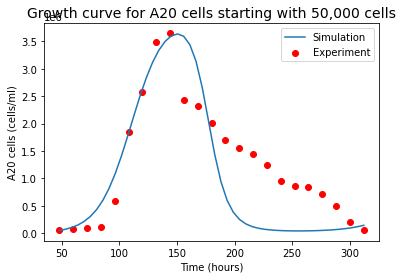

In [1]:
#modeling the growth dynamics of A20 leukemic cells. Equations have been defined to model the dynamics of the living
#and dead cells 

#imports the necessary packages 
import math
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

traindata=pd.read_csv('cellgrowth.csv') #reads into the experimental data for the growth dynamics of the cells 

def odefunc(f,t): #defines the function for the ode equations to be used in the ode solver 
    A= f[0] #Living cells in the culture 
    Ad= f[1] #dead cells in the culture 
    r=0.07 #A20 cell growth rate 1/h
    K=4e6 #maximal tumor cell population cells/ml
    mua=3.7e-8 #rate of cell death 1/h
    d=0.017 #dissolution rate of dead cells 1/h
    func=[r*A*(1-(A/K))-mua*A*Ad,mua*A*Ad-d*Ad]
    return func

t_steps= np.linspace(48,312) #vector of time from 48h to 312h (same as experiment)

ic=[5e4,2500] # initial conditions. Initial number of live cells = 50000 and dead cells =2500 (5% of living cells)

exp1=[int(i.replace(",","")) for i in traindata['Exp1'] ] #converts the cell count to integers for the experimental data

#fitting the model to the experimental data of the number of live cells in culture over time 

ODE_output = odeint(odefunc, ic, t_steps);#solves the differential equations with the initial conditions and time

plt.plot(t_steps,ODE_output[:,0]) #plots the simulated number of living cells 
plt.scatter(traindata["Time"],exp1,color='r') #plots the measured number of living cells 

#adds labels to the plot 
plt.title('Growth curve for A20 cells starting with 50,000 cells',fontsize=14)
plt.ylabel('A20 cells (cells/ml)')
plt.xlabel('Time (hours)')
plt.legend(["Simulation","Experiment"])

plt.savefig('modelfit.png')

Text(0.5, 1.0, 'A20 cell simulated growth dynamics with Chlorambucil')

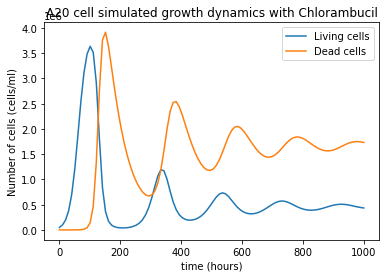

In [2]:
#Chlorambucil (chl) kills tumor cells. An equation has been defined to account for the action of chl in culture on the 
#number of living cells 

def odefunc2(f,t): 
    A= f[0] 
    Ad= f[1]
    C=f[2] #drug concentration 
    r=0.07
    K=4e6
    mua=3.7e-8
    muac=0.018 #Cytotoxicity rate in the presence of drug (h −1 )
    a=2e3 #Drug dose that produces 50% maximum effect (mL)
    d=0.017
    muca=muac*10 #Deactivation rate of drug due to killing of A20 cells (h −1 )
    muc=0.462 #Chemical deactivation rate of drug (h −1 )
    func=[r*A*(1-(A/K))-mua*A*Ad-(muac*A*C)/(a+C),mua*A*Ad-d*Ad+(muac*A*C)/(a+C),muc*C-(muca*C*A)/(a+C)]
    return func

#finding the steady state values for the three variables 

timesteps = np.linspace(0,1000,100) #list of time values 
ic2=[5e4,2500,50] #initial conditions where drug concentration is initially 50uM
x = odeint(odefunc2, ic2, timesteps); #solves the differential equation for the given initial condition 

#plots the solutions and adds labels to the plots 
plt.plot(timesteps,x[:,0:2]) #plots the living and dead cell solutions
# plt.plot(timesteps,x[:,2]) #plots the drug concentration
plt.xlabel('time (hours)')
plt.ylabel("Number of cells (cells/ml)")
plt.legend(["Living cells","Dead cells"])
plt.title('A20 cell simulated growth dynamics with Chlorambucil' )

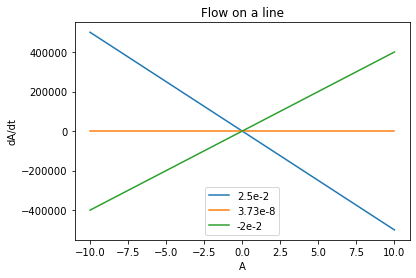

In [3]:
#Bifurcation analysis of the mua parameter with the living cells while at steady state cell death 

def flowdA(A,mua): 
    r=0.07
    K=4e6
    Ad=2e6 #steady state of dead cells ascertained from plot above 
    dAdt=r*A*(1-(A/K))-mua*A*Ad; #living cells 
    return dAdt #returns the value of the equation at values of A



a_vals=np.linspace(-10,10,50) #creates a vector of A values 

mua=[2.5e-2,3.73e-8,-2e-2] #creates a vector of different values of the parameter mua
 


for n in mua: #loops through the different parameter values
    dA_dt = [] #creates an empty vector to add in the differential equation values 
    for i in a_vals: #loops through the A value list and evaluates the equation at this value 
        dA_dt.append(flowdA(i,n)) #evaluates the differential equation at all the A values for the one specified parameter value
    plt.xlabel("A")
    plt.ylabel("dA/dt")
    plt.title("Flow on a line")
    plt.plot(a_vals,dA_dt) #plots the solutions 
    plt.legend(["2.5e-2","3.73e-8","-2e-2"])


# plt.savefig('bifur.png',bbox_inches='tight')


In [5]:
#sensitivity analysis of the parameters 

#Local sensitivity analysis 
def func(f,t, mua,d,K,r): #function that accepts the parameters for the ODEs defined above and returns the ODE values    
    A,Ad = f;
    return [r*A*(1-(A/K))-mua*A*Ad,mua*A*Ad-d*Ad]

mua= 3.7e-8
d= 0.017
K= 4e6
r= 0.07


timesteps = np.linspace(0,20,100)
y0 = [5e4,2500]; #initial conditions 

#finds the solutions to the differential equations when the parameters are changed by 1% 
y = odeint(func, y0, timesteps, args = (mua,d,K,r))
y1 = odeint(func, y0, timesteps, args = (mua*1.01,d,K,r))
y2 = odeint(func, y0, timesteps, args = (mua,d*1.01,K,r))
y3 = odeint(func, y0, timesteps, args = (mua,d,K*1.01,r))
y4 = odeint(func, y0, timesteps, args = (mua,d,K,r*1.01))



nomvalA= y[-1,0] #final Nominal A value
nomvalAd=y[-1,1] #final Nominal Ad value
print("Final Nominal A value",nomvalA,"Final Nominal A value",nomvalAd)

Final Nominal A value 194993.7196717487 Final Nominal A value 1926.0130724127853


parameter r shows greatest sensitivity


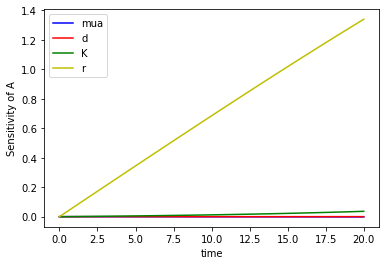

In [6]:
#plots the values of the solutions with each parameter adjustment 
plt.xlabel("time")
plt.ylabel("Sensitivity of A")
plt.plot(timesteps, ((y1[:,0] - y[:,0])/y[:,0])/0.01,'b', label = "mua");
plt.plot(timesteps, ((y2[:,0] - y[:,0])/y[:,0])/0.01,'r', label = "d");
plt.plot(timesteps,((y3[:,0] - y[:,0])/y[:,0])/0.01,'g', label = "K");
plt.plot(timesteps,((y4[:,0] - y[:,0])/y[:,0])/0.01,'y', label = "r");
plt.legend()

print("parameter r shows greatest sensitivity")

plt.savefig('Asens.png',bbox_inches='tight')

parameter d shows greatest sensitivity


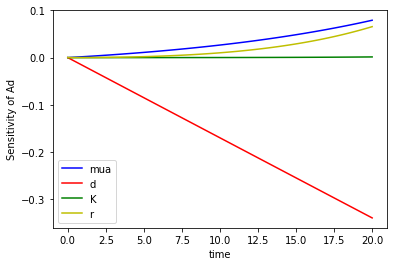

In [7]:
#plots the values of the solutions with each parameter adjustment 
plt.xlabel("time")
plt.ylabel("Sensitivity of Ad")
plt.plot(timesteps, ((y1[:,1] - y[:,1])/y[:,1])/0.01,'b', label = "mua");
plt.plot(timesteps, ((y2[:,1] - y[:,1])/y[:,1])/0.01,'r', label = "d");
plt.plot(timesteps,((y3[:,1] - y[:,1])/y[:,1])/0.01,'g', label = "K");
plt.plot(timesteps,((y4[:,1] - y[:,1])/y[:,1])/0.01,'y', label = "r");
plt.legend()

print("parameter d shows greatest sensitivity")

plt.savefig('Adsens.png',bbox_inches='tight')

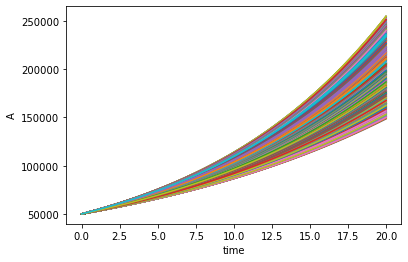

In [8]:
#global sensitivity analysis of the parameters to determine their sensitivity

#generates random values of the parameters between +/ 20% of their value
N = 1000; 
mua = np.random.uniform(3.7e-8*.8,3.7e-8*1.2,N);
d = np.random.uniform(0.017*.8,0.017*1.2,N);
K = np.random.uniform(4e6*.8,4e6*1.2,N);
r= np.random.uniform(0.07*.8,0.07*1.2,N);

A = np.zeros(N); #creates an array of zeroes for the values of A and Ad to be added 
Ad = np.zeros(N);

for m in np.arange(0,N,1): 
    output = odeint(func, y0, timesteps, args = (mua[m],d[m],K[m],r[m])); #solves the ODEs at each parameter value
    plt.plot(timesteps,output[:,0]); #plots the solutions for A
    plt.xlabel("time");
    plt.ylabel("A");
    A[m]=output[-1,0];

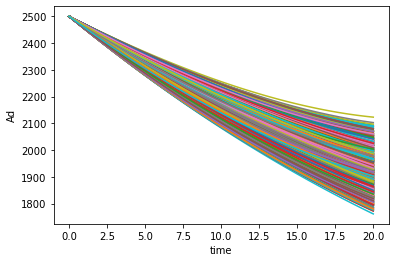

In [9]:

for m in np.arange(0,N,1): 
    output = odeint(func, y0, timesteps, args = (mua[m],d[m],K[m],r[m])); #solves the ODEs at each parameter value
    plt.plot(timesteps,output[:,1]); #plots the solutions for Ad
    plt.xlabel("time");
    plt.ylabel("Ad");
    Ad[m]=output[-1,1];

The fitted equation is A =  -0.007187059687683949 mua +  -0.003762962299401257 d + 0.04040698807528044 K 1.3347833175041406 +r
The fitted equation is Ad =  0.07852500673266066 mua +  -0.3406473798923214 d + 0.001155125834196605 K 0.06497060426454451 +r


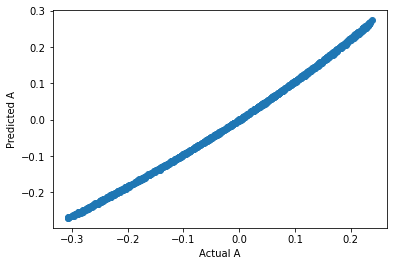

In [11]:
Aval= (nomvalA-A)/nomvalA; # normalizes the A values 
Adval= (nomvalAd-Ad)/nomvalAd; # normalizes the A values 
#carrying out linear regression on the A values to determine the sensitivity of each parameter 

#creates the X array with normalized values for each parameter 
X_A = np.c_[(3.7e-8-mua)/3.7e-8,(0.017-d)/0.017,(4e6-K)/4e6,(0.07-r)/0.07]
X_Ad = np.c_[(3.7e-8-mua)/3.7e-8,(0.017-d)/0.017,(4e6-K)/4e6,(0.07-r)/0.07]


#imports the necessary module 
from numpy.linalg import inv

#performs the linear regression 
tmpA = inv(np.matmul(np.transpose(X_A),X_A));
tmpAd = inv(np.matmul(np.transpose(X_Ad),X_Ad));

paramsA = tmpA @ np.transpose(X_A) @ Aval;
paramsAd = tmpAd @ np.transpose(X_Ad) @ Adval;
print("The fitted equation is A = ",paramsA[0], "mua + ", paramsA[1], "d +", paramsA[2],"K",paramsA[3],"+r")
print("The fitted equation is Ad = ",paramsAd[0], "mua + ", paramsAd[1], "d +", paramsAd[2],"K",paramsAd[3],"+r")

plt.plot(Aval,X_A @ paramsA,"o");
plt.ylabel("Predicted A");
plt.xlabel("Actual A");


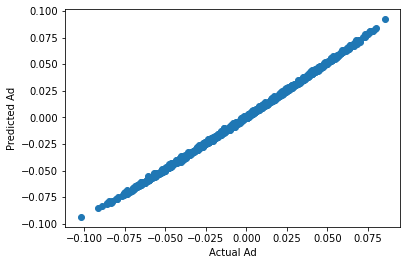

In [12]:
plt.plot(Adval,X_Ad @ paramsAd,"o");
plt.ylabel("Predicted Ad");
plt.xlabel("Actual Ad");